In [1]:
# importing librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
jnj_long_data = yf.download("JNJ", period="max", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [3]:
jnj_long_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,JNJ,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,,
1962-01-02,0.062519,0.223380,0.223380,0.222222,0.0,0
1962-01-03,0.061547,0.219907,0.221065,0.219907,0.0,345600
1962-01-04,0.060899,0.217593,0.221065,0.217593,0.0,216000
1962-01-05,0.059927,0.214120,0.215856,0.214120,0.0,129600
1962-01-08,0.058956,0.210648,0.212384,0.210648,0.0,172800


In [4]:
jnj_long_data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,JNJ,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,,
2025-01-08,142.270004,142.270004,145.589996,141.440002,145.490005,11175600
2025-01-10,142.059998,142.059998,143.669998,140.679993,141.000000,8821500
2025-01-13,144.470001,144.470001,145.070007,142.309998,142.979996,10376400
2025-01-14,144.750000,144.750000,144.809998,142.860001,144.500000,8674800
2025-01-15,144.634995,144.634995,146.050003,144.259995,145.309998,2169303


In [5]:
# check for the missing values
jnj_long_data.isnull().sum()

,,0
Price,Ticker,
Adj Close,JNJ,0
Close,JNJ,0
High,JNJ,0
Low,JNJ,0
Open,JNJ,0
Volume,JNJ,0


In [6]:
jnj_long_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15867 entries, 1962-01-02 to 2025-01-15
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, JNJ)  15867 non-null  float64
 1   (Close, JNJ)      15867 non-null  float64
 2   (High, JNJ)       15867 non-null  float64
 3   (Low, JNJ)        15867 non-null  float64
 4   (Open, JNJ)       15867 non-null  float64
 5   (Volume, JNJ)     15867 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 867.7 KB


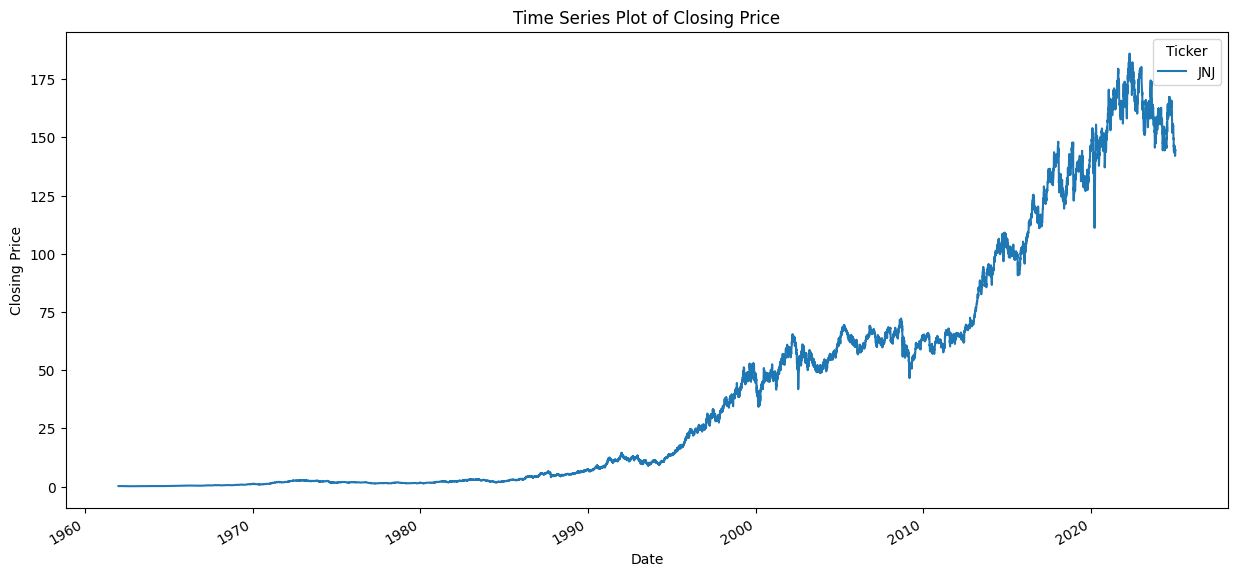

In [7]:
# time series plot
jnj_long_data['Close'].plot(figsize=(15,7))
plt.title('Time Series Plot of Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

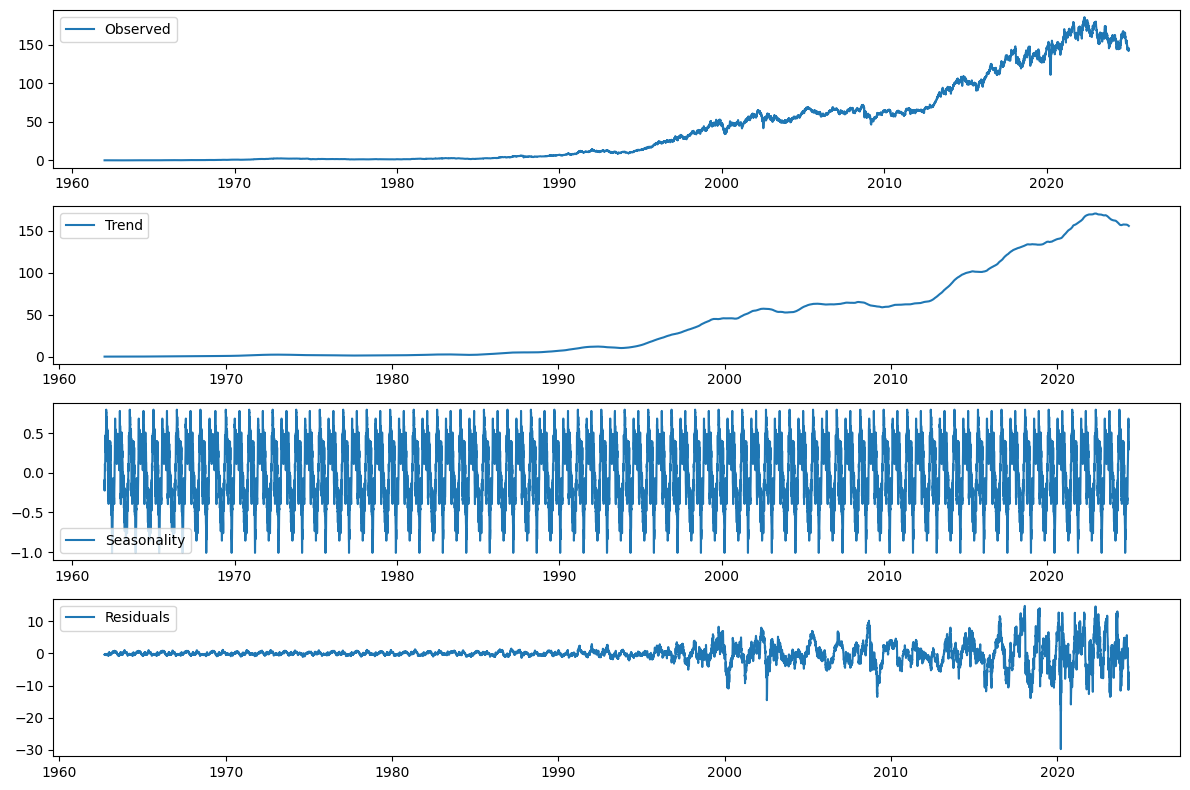

In [8]:
# Decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(jnj_long_data['Close'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

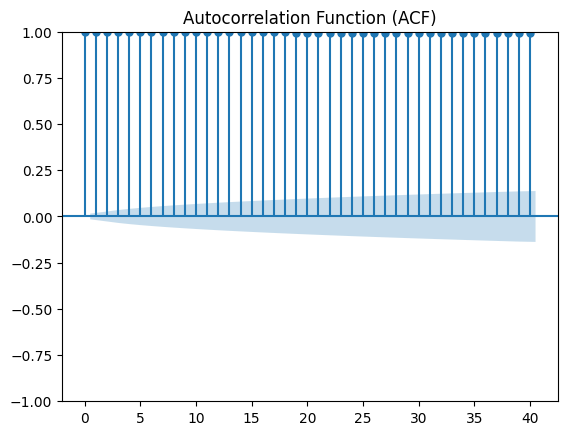

In [9]:
plt.figure(figsize=(10, 5))
plot_acf(jnj_long_data['Close'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

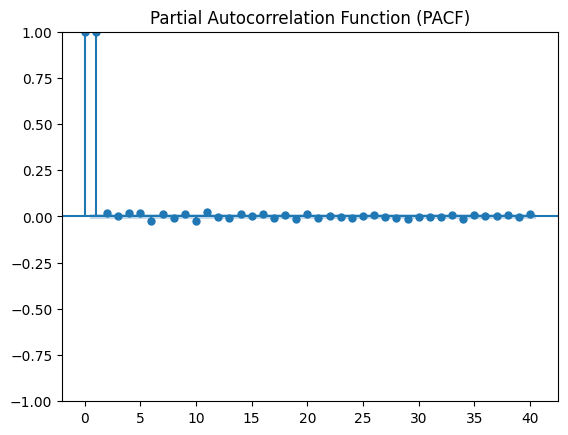

In [10]:
plt.figure(figsize=(10, 5))
plot_pacf(jnj_long_data['Close'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [11]:
# get the Date out of the index
jnj_long_data.reset_index(inplace=True)

In [12]:
# isolet the Date and Sales columns
jnj_long_data = jnj_long_data[['Date', 'Close']]

In [13]:
jnj_long_data

Price,Date,Close
Ticker,,JNJ
0,1962-01-02,0.223380
1,1962-01-03,0.219907
2,1962-01-04,0.217593
3,1962-01-05,0.214120
4,1962-01-08,0.210648
...,...,...
15862,2025-01-08,142.270004
15863,2025-01-10,142.059998
15864,2025-01-13,144.470001


In [14]:
# Split into training and testing sets based on index
train_size = int(len(jnj_long_data) * 0.8)  # 80% for training
train_data = jnj_long_data[:train_size]
test_data = jnj_long_data[train_size:]

In [15]:
# set the date coumn as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [16]:
train_data

Price,Close
Ticker,JNJ
Date,
1962-01-02,0.223380
1962-01-03,0.219907
1962-01-04,0.217593
1962-01-05,0.214120
1962-01-08,0.210648
...,...
2012-05-25,62.509998
2012-05-29,62.590000


In [17]:
test_data

Price,Close
Ticker,JNJ
Date,
2012-06-04,62.340000
2012-06-05,62.209999
2012-06-06,62.799999
2012-06-07,62.799999
2012-06-08,62.980000
...,...
2025-01-08,142.270004
2025-01-10,142.059998


In [18]:
# look at train data date range
train_data.index.min(), train_data.index.max()

(Timestamp('1962-01-02 00:00:00'), Timestamp('2012-06-01 00:00:00'))

In [19]:
# look at the test data date range
test_data.index.min(), test_data.index.max()

(Timestamp('2012-06-04 00:00:00'), Timestamp('2025-01-15 00:00:00'))

In [20]:
scaler = MinMaxScaler()

train_data.loc[:, 'x'] = scaler.fit_transform(train_data[['Close']])
test_data.loc[:, 'x'] = scaler.transform(test_data[['Close']])

In [21]:
# Create sequences for the LSTM model
sequence_length = 100
train_sequences = []
test_sequences = []

for i in range(len(train_data) - sequence_length):
    train_sequences.append(train_data['x'].iloc[i:i+sequence_length].values)

for i in range(len(test_data) - sequence_length):
    test_sequences.append(test_data['x'].iloc[i:i+sequence_length].values)

train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)

In [22]:
# Prepare train and test targets
train_targets = train_data['x'].iloc[sequence_length:].values
test_targets = test_data['x'].iloc[sequence_length:].values

In [23]:
import time
start_time = time.time()

# Create and train an LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_sequences.reshape(-1, sequence_length, 1), train_targets,
epochs=5, batch_size=32)

# Make predictions
test_predictions = model.predict(
                   test_sequences.reshape(-1, sequence_length, 1))

print(time.time() - start_time)

# Inverse transform the predictions to the original scale
test_predictions = scaler.inverse_transform(test_predictions).flatten()
test_targets = scaler.inverse_transform(test_targets.reshape(-1, 1))

Epoch 1/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0724
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 2.0661e-04
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 1.3124e-04
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 1.1688e-04
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - loss: 1.0731e-04
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
102.54229092597961


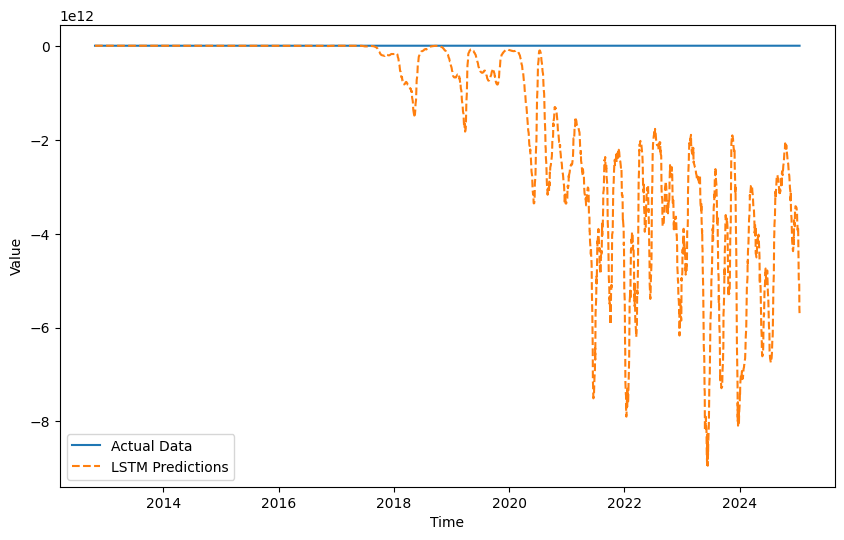

In [24]:
# Plot the original data and LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_targets,
label="Actual Data", linestyle='-')
plt.plot(test_data.index[sequence_length:], test_predictions,
label="LSTM Predictions", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(False)
plt.show()

In [25]:
# measure of prediction accuracy
test_predictions_df = pd.DataFrame(test_predictions, columns = ["LSTM"])
test_targets_df = pd.DataFrame(test_targets, columns = ["actuals"])
predictions = pd.concat([test_predictions_df, test_targets_df], axis=1)

wape = (predictions['actuals'] - predictions['LSTM']).abs().sum() / predictions['actuals'].sum()

print(wape * 100)

1161237779545.537


In [26]:
# predict for the next one year
last_sequence = test_sequences[-1]
predicted_values = []

for _ in range(365):
    predicted_value = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = predicted_value

predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

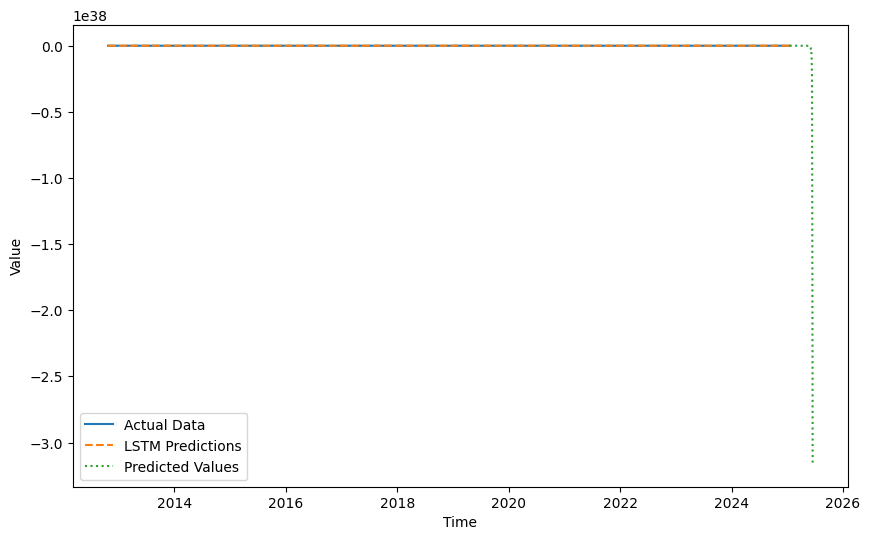

In [27]:
# show in plot
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_targets,
label="Actual Data", linestyle='-')
plt.plot(test_data.index[sequence_length:], test_predictions,
label="LSTM Predictions", linestyle='--')

# Generate a date range for the predicted values
# Assuming your test_data has a daily frequency
from pandas.tseries.offsets import DateOffset
future_dates = pd.date_range(start=test_data.index[-1], periods=365 + 1, freq='D')[1:]  # Exclude the start date

# Now plot the predicted values against the future dates
plt.plot(future_dates, predicted_values,
         label="Predicted Values", linestyle=':')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(False)
plt.show()